In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import RobustScaler 
from sklearn.model_selection import train_test_split

C:\Users\APC\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [17]:
train_2016 = pd.read_csv('./../preprocessed data/df_train_2016.csv')
predict_2016 = pd.read_csv('./../preprocessed data/df_predict_2016.csv')

train_2017 = pd.read_csv('./../preprocessed data/df_train_2017.csv')
predict_2017 = pd.read_csv('./../preprocessed data/df_predict_2017.csv')

sample = pd.read_csv("./../data/sample_submission.csv")

In [28]:
def standardize(df):
    numerical_columns = ['bathroomcnt', 'bedroomcnt','calculatedfinishedsquarefeet',
       'fireplacecnt', 'garagecarcnt', 'garagetotalsqft','latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum','unitcnt',
       'yardbuildingsqft17', 'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'age']
    for col in numerical_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        Q2 = df[col].quantile(0.5)
        if Q3>Q1:
            df[col] = (df[col]-Q2)/(Q3-Q1)
    return df

In [29]:
def polynomial(df, most_corr_feat):
    for var in most_corr_feat:
        s2_var_name = var + '-s2'
        s3_var_name = var + '-s3'
        sq_var_name = var + '-sqrt'

        # Create features 
        df[s2_var_name] = df[var] ** 2 
        df[s3_var_name] = df[var] ** 3 
        df[sq_var_name] = np.sqrt(df[var]) 
    return df

In [30]:
def outliner_drop(df):
    Q1 = df['logerror'].quantile(0.25)
    Q3 = df['logerror'].quantile(0.75)
    IQR = Q3-Q1
    lower_lim = Q1 - 1.5*IQR
    upper_lim = Q3 + 1.5*IQR
    df=df[df.logerror >= lower_lim ]
    df=df[df.logerror <= upper_lim ]
    return df

# 2016 

In [31]:
numerical_columns = ['logerror','bathroomcnt', 'bedroomcnt','calculatedfinishedsquarefeet',
       'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum','unitcnt',
       'yardbuildingsqft17', 'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'age']
corr = train_2016[numerical_columns].corr()
most_corr_feat = corr.logerror.abs().sort_values(ascending=False)[1:9].index
most_corr_feat

Index(['calculatedfinishedsquarefeet', 'bathroomcnt', 'bedroomcnt',
       'structuretaxvaluedollarcnt', 'age', 'poolcnt', 'garagetotalsqft',
       'fireplacecnt'],
      dtype='object')

In [32]:
train_16 = train_2016.copy()
train_16 = polynomial(train_16,most_corr_feat)
train_16 = standardize(train_16)
train_16 = outliner_drop(train_16)
y = train_16['logerror']
train_16 = train_16.drop(['logerror'],axis=1)

predict_16 = predict_2016.drop(['parcelid'],axis=1)
predict_16 = polynomial(predict_16,most_corr_feat)
predict_16 = standardize(predict_16)

In [33]:
# Set of alpha values to test
alphas = np.logspace(7,10)
#alphas = np.arange(28800000,28810000,100)
print(f"Testing with alphas={alphas}")

# Tune Ridge Regression
ridgecv = RidgeCV(alphas=alphas)
ridgecv.fit(train_16, y)
print(f"Best Ridge Alpha: {ridgecv.alpha_}")

Testing with alphas=[1.00000000e+07 1.15139540e+07 1.32571137e+07 1.52641797e+07
 1.75751062e+07 2.02358965e+07 2.32995181e+07 2.68269580e+07
 3.08884360e+07 3.55648031e+07 4.09491506e+07 4.71486636e+07
 5.42867544e+07 6.25055193e+07 7.19685673e+07 8.28642773e+07
 9.54095476e+07 1.09854114e+08 1.26485522e+08 1.45634848e+08
 1.67683294e+08 1.93069773e+08 2.22299648e+08 2.55954792e+08
 2.94705170e+08 3.39322177e+08 3.90693994e+08 4.49843267e+08
 5.17947468e+08 5.96362332e+08 6.86648845e+08 7.90604321e+08
 9.10298178e+08 1.04811313e+09 1.20679264e+09 1.38949549e+09
 1.59985872e+09 1.84206997e+09 2.12095089e+09 2.44205309e+09
 2.81176870e+09 3.23745754e+09 3.72759372e+09 4.29193426e+09
 4.94171336e+09 5.68986603e+09 6.55128557e+09 7.54312006e+09
 8.68511374e+09 1.00000000e+10]
Best Ridge Alpha: 26826957.95279727


In [34]:
rlr = Ridge(alpha=ridgecv.alpha_)
rlr.fit(train_16, y)

y_pred=rlr.predict(train_16)
df_y=abs(y-y_pred)
MAE=df_y.sum()/len(y)
print(MAE)

0.03544792232007029


C:\Users\APC\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.88362e-33): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [35]:
Y = rlr.predict(predict_16)
sample['201610'] = Y
sample['201611'] = Y
sample['201612'] = Y

# 2017

In [36]:
numerical_columns = ['logerror','bathroomcnt', 'bedroomcnt','calculatedfinishedsquarefeet',
       'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum','unitcnt',
       'yardbuildingsqft17', 'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'age']
corr = train_2017[numerical_columns].corr()
most_corr_feat = corr.logerror.abs().sort_values(ascending=False)[1:9].index
most_corr_feat

Index(['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt',
       'garagetotalsqft', 'garagecarcnt', 'lotsizesquarefeet', 'poolcnt',
       'structuretaxvaluedollarcnt'],
      dtype='object')

In [37]:
train_17 = train_2017.copy()
train_17 = polynomial(train_17,most_corr_feat)
train_17 = standardize(train_17)
train_17 = outliner_drop(train_17)
y = train_17['logerror']
train_17 = train_17.drop(['logerror'],axis=1)

predict_17 = predict_2017.drop(['parcelid'],axis=1)
predict_17 = polynomial(predict_17,most_corr_feat)
predict_17 = standardize(predict_17)

In [38]:
# Set of alpha values to test
alphas = np.logspace(7,10)
#alphas = np.arange(28800000,28810000,100)
print(f"Testing with alphas={alphas}")

# Tune Ridge Regression
ridgecv = RidgeCV(alphas=alphas)
ridgecv.fit(train_17, y)
print(f"Best Ridge Alpha: {ridgecv.alpha_}")

Testing with alphas=[1.00000000e+07 1.15139540e+07 1.32571137e+07 1.52641797e+07
 1.75751062e+07 2.02358965e+07 2.32995181e+07 2.68269580e+07
 3.08884360e+07 3.55648031e+07 4.09491506e+07 4.71486636e+07
 5.42867544e+07 6.25055193e+07 7.19685673e+07 8.28642773e+07
 9.54095476e+07 1.09854114e+08 1.26485522e+08 1.45634848e+08
 1.67683294e+08 1.93069773e+08 2.22299648e+08 2.55954792e+08
 2.94705170e+08 3.39322177e+08 3.90693994e+08 4.49843267e+08
 5.17947468e+08 5.96362332e+08 6.86648845e+08 7.90604321e+08
 9.10298178e+08 1.04811313e+09 1.20679264e+09 1.38949549e+09
 1.59985872e+09 1.84206997e+09 2.12095089e+09 2.44205309e+09
 2.81176870e+09 3.23745754e+09 3.72759372e+09 4.29193426e+09
 4.94171336e+09 5.68986603e+09 6.55128557e+09 7.54312006e+09
 8.68511374e+09 1.00000000e+10]
Best Ridge Alpha: 1599858719.6060574


In [40]:
rlr = Ridge(alpha=ridgecv.alpha_)
rlr.fit(train_17, y)

y_pred=rlr.predict(train_17)
df_y=abs(y-y_pred)
MAE=df_y.sum()/len(y)
print(MAE)

0.034826477951810396


C:\Users\APC\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.2452e-33): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [41]:
Y = rlr.predict(predict_17)
sample['201710'] = Y
sample['201711'] = Y
sample['201712'] = Y

In [48]:
sample.to_csv('./../submission/ridge.csv', index=False, float_format='%.4f')

In [43]:
sample.boxplot

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.003768,0.003768,0.003768,0.004874,0.004874,0.004874
1,10759547,0.003732,0.003732,0.003732,0.004687,0.004687,0.004687
2,10843547,-21.431179,-21.431179,-21.431179,-17.498541,-17.498541,-17.498541
3,10859147,0.026977,0.026977,0.026977,0.026356,0.026356,0.026356
4,10879947,0.003789,0.003789,0.003789,0.005461,0.005461,0.005461
...,...,...,...,...,...,...,...
2985212,168176230,0.003368,0.003368,0.003368,0.004702,0.004702,0.004702
2985213,14273630,0.003368,0.003368,0.003368,0.006224,0.006224,0.006224
2985214,168040630,0.003368,0.003368,0.003368,0.004056,0.004056,0.004056
2985215,168040830,0.003368,0.003368,0.003368,0.008133,0.008133,0.008133


<AxesSubplot:>

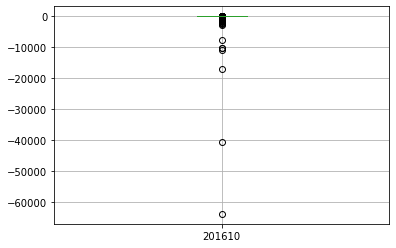

In [46]:
sample.boxplot('201610')

<AxesSubplot:>

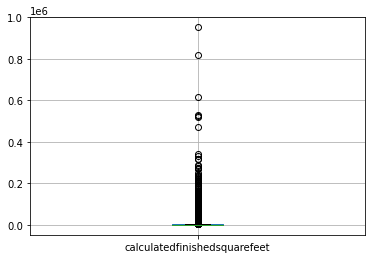

In [47]:
predict_2016.boxplot('calculatedfinishedsquarefeet')